In [26]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline
# Import tensorflow dependencies - Functional API
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[]

## **1. Create Folder structure**

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

## **2. Collecting datasets**

> **Collect ankor images**

In [5]:
# http://vis-www.cs.umass.edu/lfw/

In [6]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

> **Collect positive and anchor classes**

In [7]:
# Import uuid library to generate unique image names
import uuid

In [8]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/67a5ef6a-23e0-11ed-bfcb-5359c2c96ea9.jpg'

In [19]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # show images back to screen
    cv2.imshow('Image collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame)

## **3. Data Augumentation**

In [20]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [21]:
import os
import uuid

In [25]:
img_path = "/home/tuandinh/Desktop/Deep Facial Recognition App from Paper/data/anchor/7ddb0198-23e1-11ed-bfcb-5359c2c96ea9.jpg"
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

## **4. Load and Preprocess Images**

> **Load images**

In [30]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

In [31]:
dir_test = anchor.as_numpy_iterator()

In [32]:
print(dir_test.next())

b'data/anchor/bfb3bc0e-23e1-11ed-bfcb-5359c2c96ea9.jpg'


> **Preprocessing**

In [34]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load image
    img = tf.image.decode_jpeg(byte_img)

    #preprocessing step
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [37]:
img = preprocess('data/anchor/7ddb0198-23e1-11ed-bfcb-5359c2c96ea9.jpg')

In [38]:
img.numpy().max() 

1.0

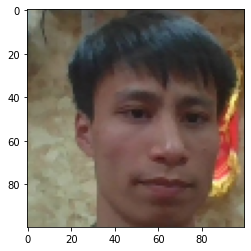

In [40]:
plt.imshow(img)

> **Create Labelled Dataset**

In [41]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [45]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [42]:
samples = data.as_numpy_iterator()

In [43]:
exampple = samples.next()

In [44]:
exampple

(b'data/anchor/8854e3c9-23e1-11ed-bfcb-5359c2c96ea9.jpg',
 b'data/positive/626645f3-23e2-11ed-bfcb-5359c2c96ea9.jpg',
 1.0)

> **Build Train and Test Partition**

In [46]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [48]:
res = preprocess_twin(*exampple)
len(res)

3

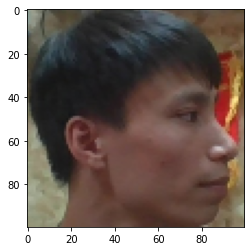

In [51]:
plt.imshow(res[0])

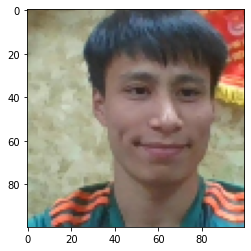

In [52]:
plt.imshow(res[1])

In [54]:
print(f"Result if positive {res[2]}")

Result if positive 1.0
